# Project Scope
The goal of this project is to analyze biodiversity data from the National Parks Service about endangered species in different national parks.

For the analysis, descriptive statistics and data visualization techniques will be employed to understand the data better.

Some questions the project seeks to answer:
+ What is the distribution of conservation status for the different species?
+ Are certain types of species more likely to be endangered?
+ Are the differences between type of species and their conservation status significant?
+ Which species is most rare and what is their distribution amongst parks?
+ Which species is most prevalent and what is their distribution amongst parks?
+ Which species is spotted the most at each park?

**Data Sources:**

Both `observations.csv` (recorded sightings of different species at several national parks for the "past 7 days") and `species.csv` (data about different species and their conservation status) were provided by [Codecademy](https://www.codecademy.com/).

Note: The data for this project is inspired by real data, but is mostly fictional.

## Import Python Modules

In [51]:
import textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency

%matplotlib inline

## Load & Inspect Data

In [2]:
# Observations data
obs_df = pd.read_csv('./observations.csv')

obs_df.head()

scientific_name                            park_name  observations
0        Vicia benghalensis  Great Smoky Mountains National Park            68
1            Neovison vison  Great Smoky Mountains National Park            77
2         Prunus subcordata               Yosemite National Park           138
3      Abutilon theophrasti                  Bryce National Park            84
4  Githopsis specularioides  Great Smoky Mountains National Park            85

In [3]:
print('Observations data:\n')
print(obs_df.info())
print(obs_df.describe())
print(obs_df.isna().sum())

Observations data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23296 entries, 0 to 23295
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   scientific_name  23296 non-null  object
 1   park_name        23296 non-null  object
 2   observations     23296 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 546.1+ KB
None
       observations
count  23296.000000
mean     142.287904
std       69.890532
min        9.000000
25%       86.000000
50%      124.000000
75%      195.000000
max      321.000000
scientific_name    0
park_name          0
observations       0
dtype: int64


Observations data:
+ 23296 entries
+ 3 columns (scientific name of species, park name, number of observations)
+ Data types: 2 object (nominal/unordered categorical), 1 integer (quantitative)
+ No missing values

In [4]:
# Species_info data
spec_df = pd.read_csv('./species_info.csv')

spec_df.head()

category                scientific_name  \
0   Mammal  Clethrionomys gapperi gapperi   
1   Mammal                      Bos bison   
2   Mammal                     Bos taurus   
3   Mammal                     Ovis aries   
4   Mammal                 Cervus elaphus   

                                        common_names conservation_status  
0                           Gapper's Red-Backed Vole                 NaN  
1                              American Bison, Bison                 NaN  
2  Aurochs, Aurochs, Domestic Cattle (Feral), Dom...                 NaN  
3  Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)                 NaN  
4                                      Wapiti Or Elk                 NaN

In [5]:
print('Species info data:\n')
print(spec_df.info())
print(spec_df.describe())
print(spec_df.isna().sum())

Species info data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824 entries, 0 to 5823
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category             5824 non-null   object
 1   scientific_name      5824 non-null   object
 2   common_names         5824 non-null   object
 3   conservation_status  191 non-null    object
dtypes: object(4)
memory usage: 182.1+ KB
None
              category    scientific_name        common_names  \
count             5824               5824                5824   
unique               7               5541                5504   
top     Vascular Plant  Castor canadensis  Brachythecium Moss   
freq              4470                  3                   7   

       conservation_status  
count                  191  
unique                   4  
top     Species of Concern  
freq                   161  
category                  0
scientific_name           0
common

Species data:
+ 5824 entries
+ 4 columns (species category, scientific name of species, species common name, species conservation status)
+ Data types: 4 object (unordered categorical, nominal, ordered categorical)
+ 5633 missing values (conservation status -> species without concern)

## Explore Data

In [6]:
# Unique species
species = spec_df.scientific_name
num_species = species.nunique()

print(f'Number of species: {num_species}')

Number of species: 5541


In [7]:
# Unique categories
categories = spec_df.category
num_cat = categories.nunique()
unique_categories = categories.unique()

print(f'Number of categories: {num_cat}')
print('Categories: ', unique_categories)

Number of categories: 7
Categories:  ['Mammal' 'Bird' 'Reptile' 'Amphibian' 'Fish' 'Vascular Plant'
 'Nonvascular Plant']


In [8]:
categories.value_counts()

Vascular Plant       4470
Bird                  521
Nonvascular Plant     333
Mammal                214
Fish                  127
Amphibian              80
Reptile                79
Name: category, dtype: int64

In [9]:
# Conservation status
status = spec_df.conservation_status
num_status = status.nunique()
unique_status = status.unique()

print('Categories of conservation status:', num_status)
print('Conservation status:', unique_status)

Categories of conservation status: 4
Conservation status: [nan 'Species of Concern' 'Endangered' 'Threatened' 'In Recovery']


In [10]:
status.value_counts()

Species of Concern    161
Endangered             16
Threatened             10
In Recovery             4
Name: conservation_status, dtype: int64

In [11]:
# National parks
parks = obs_df.park_name
num_parks = parks.nunique()
unique_parks = parks.unique()

print('Number of parks:', num_parks)
print('Unique parks:', unique_parks)

Number of parks: 4
Unique parks: ['Great Smoky Mountains National Park' 'Yosemite National Park'
 'Bryce National Park' 'Yellowstone National Park']


In [12]:
parks.value_counts()

Yellowstone National Park              5824
Great Smoky Mountains National Park    5824
Bryce National Park                    5824
Yosemite National Park                 5824
Name: park_name, dtype: int64

In [13]:
# Total number of observations in the last 7 days
print('Total number of observations:', obs_df.observations.sum())

Total number of observations: 3314739


## Analyze Data

### Distribution of Conservation Status by Category

In [14]:
# Filling missing values with 'No concern'
spec_df.fillna('No Concern', inplace=True)
status = spec_df.conservation_status

status.value_counts()

No Concern            5633
Species of Concern     161
Endangered              16
Threatened              10
In Recovery              4
Name: conservation_status, dtype: int64

In [15]:
statusCategory = spec_df[spec_df.conservation_status != 'No Concern'].groupby(['conservation_status', 'category']).scientific_name.count().unstack()

statusCategory

category             Amphibian  Bird  Fish  Mammal  Nonvascular Plant  \
conservation_status                                                     
Endangered                 1.0   4.0   3.0     7.0                NaN   
In Recovery                NaN   3.0   NaN     1.0                NaN   
Species of Concern         4.0  72.0   4.0    28.0                5.0   
Threatened                 2.0   NaN   4.0     2.0                NaN   

category             Reptile  Vascular Plant  
conservation_status                           
Endangered               NaN             1.0  
In Recovery              NaN             NaN  
Species of Concern       5.0            43.0  
Threatened               NaN             2.0

+ Endangered: 1 amphibian, 4 birds, 3 fish, 7 mammals, 1 vascular plant
+ In recovery: 3 birds, 1 mammal
+ Species of concern: 4 amphibian, 72 birds, 4 fish, 28 mammals, 5 nonvascular plants, 5 reptiles, 42 vascular plants
+ Threatened: 2 amphibian, 4 fish, 2 mammals, 2 vascular plants
+ It seems that birds recover better compared to mammals.

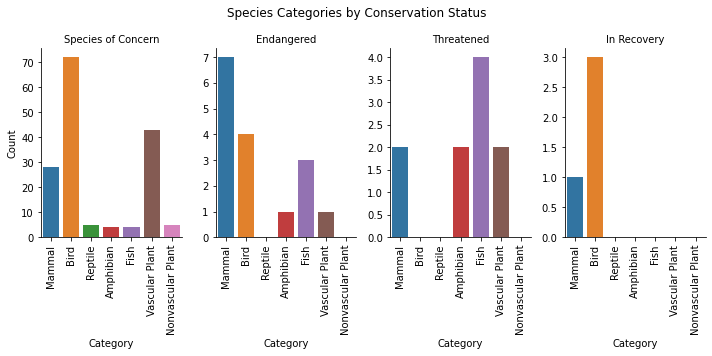

In [16]:
g = sns.catplot(x="category", col="conservation_status", data=spec_df[spec_df.conservation_status != 'No Concern'], kind="count", sharey=False, height=5, aspect=.5)

plt.suptitle('Species Categories by Conservation Status')
g.set_titles(col_template='{col_name}')
g.set_axis_labels('Category', 'Count')
g.set_xticklabels(rotation='vertical')
g.tight_layout()

plt.show()

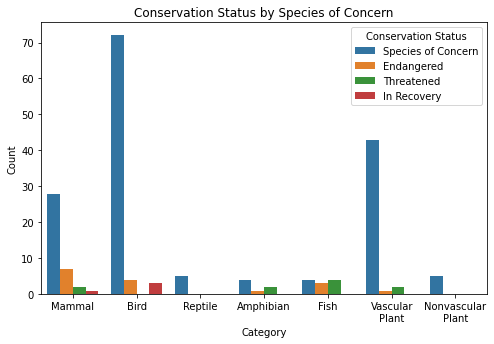

In [66]:
fig = plt.figure(figsize=(8,5))

ax = sns.countplot(data=spec_df[spec_df.conservation_status != 'No Concern'], x='category', hue='conservation_status')

plt.title('Conservation Status by Species of Concern')
plt.xlabel('Category')
plt.ylabel('Count')
plt.legend(title='Conservation Status', loc='upper right')
ax.set_xticklabels(textwrap.fill(x.get_text(), 12) for x in ax.get_xticklabels())

plt.show()

### In Conservation vs Category

In [18]:
# Add column 'is_protected' for species in conservation (other than 'No Concern')
spec_df['is_protected'] = spec_df.conservation_status != 'No Concern'

spec_df.head()

category                scientific_name  \
0   Mammal  Clethrionomys gapperi gapperi   
1   Mammal                      Bos bison   
2   Mammal                     Bos taurus   
3   Mammal                     Ovis aries   
4   Mammal                 Cervus elaphus   

                                        common_names conservation_status  \
0                           Gapper's Red-Backed Vole          No Concern   
1                              American Bison, Bison          No Concern   
2  Aurochs, Aurochs, Domestic Cattle (Feral), Dom...          No Concern   
3  Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)          No Concern   
4                                      Wapiti Or Elk          No Concern   

   is_protected  
0         False  
1         False  
2         False  
3         False  
4         False

In [19]:
# Group by category and is_protected and count protected vs not protected species
cat_counts = spec_df.groupby(['category', 'is_protected']).scientific_name.nunique().reset_index().pivot(index='category', columns='is_protected', values='scientific_name').reset_index()

cat_counts.columns = ['category', 'not_protected', 'protected']

# Add column 'percent_protected' for percentage of protected species
cat_counts['percent_protected'] = cat_counts.protected / (cat_counts.protected + cat_counts.not_protected) * 100

cat_counts

category  not_protected  protected  percent_protected
0          Amphibian             72          7           8.860759
1               Bird            413         75          15.368852
2               Fish            115         11           8.730159
3             Mammal            146         30          17.045455
4  Nonvascular Plant            328          5           1.501502
5            Reptile             73          5           6.410256
6     Vascular Plant           4216         46           1.079305

Highest percentages of species that are under protection:
+ Mammals: ~17%
+ Birds: ~15%

### Statistical Significance

To test if there is a dependency between the species category and the conservation status a chi square test is run. The standard p-value (significance threshold) is 0.05. If the p-value returned from the test is smaller than the significance threshold, the variables are dependent.

In [20]:
# Contingency table
Xtab = pd.crosstab(spec_df.category, spec_df.is_protected, values=spec_df.scientific_name, aggfunc=lambda x: len(x.unique()))

print(Xtab)

# Chi square test
chi2, p, dof, expected = chi2_contingency(Xtab)

print('\nChi2 p-value:', p)
print('\nExpected values:\n', expected)

is_protected       False  True 
category                       
Amphibian             72      7
Bird                 413     75
Fish                 115     11
Mammal               146     30
Nonvascular Plant    328      5
Reptile               73      5
Vascular Plant      4216     46

Chi2 p-value: 5.5108280473137505e-89

Expected values:
 [[7.64483941e+01 2.55160592e+00]
 [4.72238181e+02 1.57618188e+01]
 [1.21930350e+02 4.06964995e+00]
 [1.70315410e+02 5.68459040e+00]
 [3.22244497e+02 1.07555034e+01]
 [7.54806929e+01 2.51930711e+00]
 [4.12434248e+03 1.37657524e+02]]


The p-value from the test is smaller than the significance threshold, which means that the difference of conservation status of at least one pair of species categories is significant.

Since the analysis is 2x7, post hoc tests have to be conducted to test where the relationship is between the different categories of each variable. The Bonferroni-adjusted p-value method is used.

In [21]:
# Create dummies dataframe for post hoc tests
dummies = pd.get_dummies(spec_df['category'])
dummies.head()

Amphibian  Bird  Fish  Mammal  Nonvascular Plant  Reptile  Vascular Plant
0          0     0     0       1                  0        0               0
1          0     0     0       1                  0        0               0
2          0     0     0       1                  0        0               0
3          0     0     0       1                  0        0               0
4          0     0     0       1                  0        0               0

In [22]:
# Post hoc tests for all categories
for series in dummies:
    nl = '\n'
    
    crosstab = pd.crosstab(dummies[f'{series}'], spec_df.is_protected, values=spec_df.scientific_name, aggfunc=lambda x: len(x.unique()))
    print(crosstab, nl)
    
    chi2, p, dof, expected = chi2_contingency(crosstab)
    print(f"Chi2 value = {chi2}{nl}p-value = {p}{nl}Degrees of freedom = {dof}{nl}")

is_protected  False  True 
Amphibian                 
0              5291    172
1                72      7 

Chi2 value = 6.405033847063912
p-value = 0.011379725714129443
Degrees of freedom = 1

is_protected  False  True 
Bird                      
0              4950    104
1               413     75 

Chi2 value = 248.04168080289367
p-value = 6.940288342727028e-56
Degrees of freedom = 1

is_protected  False  True 
Fish                      
0              5248    168
1               115     11 

Chi2 value = 10.743821068228172
p-value = 0.001046280736437933
Degrees of freedom = 1

is_protected  False  True 
Mammal                    
0              5217    149
1               146     30 

Chi2 value = 106.48575412002755
p-value = 5.770583896030514e-25
Degrees of freedom = 1

is_protected       False  True 
Nonvascular Plant              
0                   5035    174
1                    328      5 

Chi2 value = 2.8233764825613794
p-value = 0.09290079010788672
Degrees of freedom 

The Bonferroni-adjusted p-value is calculated by the formula is p/N, where p = the original tests p-value (here: 0.05) and N = the number of planned pairwise comparisons (here: 7).

In [23]:
adj_p = 0.05 / 7
print(adj_p)

0.0071428571428571435


Using the Bonferroni-adjusted p-value of 0.007, 4 of 7 of the pairwise comparisons are significant. There is a significant relationship between the conservation status and the category:
+ Bird
+ Fish
+ Mammal
+ Vascular Plant

Comparing the actual values and the expected values for these variable pairs, it can be stated that Birds, Fish and Mammals show a statistically significant higher rate of needed protection compared to the other species categories, whereas Vascular Plants show a significant lower rate of needed protection.

### Most Rare and Most Prevalent Species & their Park Distribution

In [44]:
# Total of sightings per species
observations = obs_df.groupby('scientific_name').observations.sum().sort_values()
print(observations)

scientific_name
Grus americana            131
Canis rufus               137
Vermivora bachmanii       141
Noturus baileyi           143
Rana sierrae              144
                         ... 
Puma concolor            1711
Hypochaeris radicata     1720
Castor canadensis        1725
Holcus lanatus           1780
Streptopelia decaocto    1785
Name: observations, Length: 5541, dtype: int64


In [46]:
print('Most rare:\n', spec_df.common_names[spec_df.scientific_name == 'Grus americana'])
print('Most prevalent:\n', spec_df.common_names[spec_df.scientific_name == 'Streptopelia decaocto'])

Most rare:
 173    Whooping Crane
Name: common_names, dtype: object
Most prevalent:
 3077                            Eurasian Collared-Dove
3140    Eurasian Collared Dove, Eurasian Collared-Dove
4514                            Eurasian Collared Dove
Name: common_names, dtype: object


+ Most rare species: Whooping Crane (Grus americana)
+ Most prevalent species: Eurasian Collared Dove (Streptopelia decaocto)

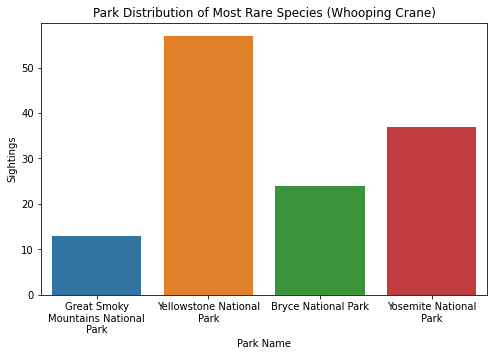

In [68]:
# Distribution of most rare species
fig = plt.figure(figsize=(8,5))

ax = sns.barplot(data=obs_df[obs_df.scientific_name == 'Grus americana'], x='park_name', y='observations')

plt.title('Park Distribution of Most Rare Species (Whooping Crane)')
plt.xlabel('Park Name')
plt.ylabel('Sightings')
ax.set_xticklabels(textwrap.fill(x.get_text(), 20) for x in ax.get_xticklabels())

plt.show()

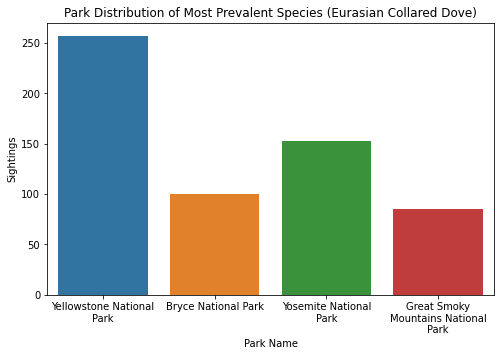

In [71]:
# Distribution of most prevalent species
fig = plt.figure(figsize=(8,5))

ax = sns.barplot(data=obs_df[obs_df.scientific_name == 'Streptopelia decaocto'], x='park_name', y='observations', ci=None)

plt.title('Park Distribution of Most Prevalent Species (Eurasian Collared Dove)')
plt.xlabel('Park Name')
plt.ylabel('Sightings')
ax.set_xticklabels(textwrap.fill(x.get_text(), 20) for x in ax.get_xticklabels())

plt.show()

### Most Spotted Species at Each Park

In [97]:
# Group by park and species and get most observations
observations_park = obs_df.groupby(['park_name', 'scientific_name']).observations.sum().sort_values(ascending=False).reset_index()

parks = list(obs_df.park_name.unique())

print('Most observed species:\n')

for park in parks:
    species_sci = observations_park[observations_park.park_name == park].scientific_name.iloc[0]
    species_name = spec_df[spec_df.scientific_name == species_sci].common_names.iloc[0]
    species_obs = observations_park[observations_park.park_name == park].observations.iloc[0]
    print(f'{park}: {species_name} ({species_sci}), {species_obs}\n')

Most observed species:

Great Smoky Mountains National Park: Eurasian Collared-Dove (Streptopelia decaocto), 256

Yosemite National Park: Cat's Ear, Spotted Cat's-Ear (Hypochaeris radicata), 505

Bryce National Park: Rock Dove (Columba livia), 339

Yellowstone National Park: Common Velvet Grass, Velvetgrass (Holcus lanatus), 805



Most observed species in each park:
+ Great Smoky Mountains National Park:
    + Common Name: Eurasian Collared Dove
    + Scientific Name: Streptopelia decaocto
    + Sightings: 256
+ Yosemite National Park:
    + Common Name: (Spotted) Cat's Ear
    + Scientific Name: Hypochaeris radicata
    + Sightings: 505
+ Bryce National Park:
    + Common Name: Rock Dove
    + Scientific Name: Columba livia
    + Sightings: 339
+ Yellowstone National Park:
    + Common Name: (Common) Velvetgrass
    + Scientific Name: Holcus lanatus
    + Sightings: 805

## Conclusions

During the analysis of this project, it was possible to make several data visualizations and inferences about the various species in four National Parks which comprised this dataset.

The project was also able to answer the questions posed in the beginning:
+ What is the distribution of conservation status for the different species?
    + The majority of species are not in conservation (5633 vs 191).
+ Are certain types of species more likely to be endangered?
    + Birds and Mammals have the highest percentage of being in protection. However, Birds seem to recover better compared to Mammals.
+ Are the differences between type of species and their conservation status significant?
    + Birds, Fish and Mammals show a statistically significant higher rate of needed protection compared to the other species categories, whereas Vascular Plants show a significant lower rate of needed protection.
+ Which species is most rare and what is their distribution amongst parks?
    + The Whooping Crane (Grus americana) seems to be the most rare species and can be found most in Yellowstone National Park.
+ Which species is most prevalent and what is their distribution amongst parks?
    + The Eurasian Collared Dove (Streptopelia decaocto) is the most prevalent species and can be found most in Yellowstone National Park.
+ Which species is spotted the most at each park?
    + At Great Smoky Mountains National Park the Eurasian Collared Dove (Streptopelia decaocto) is spotted most.
    + At Yosemite National Park the (Spotted) Cat's Ear (Hypochaeris radicata) is spotted most.
    + At Bryce National Park the Rock Dove (Columba livia) is spotted most.
    + At Yellowstone National Park the (Common) Velvetgrass (Holcus lanatus) is spotted most.

## Further Research

This dataset only included observations from the "last 7 days". If there were observations for a longer time period, changes over time could be analyzed, e.g. how the conservation status for various species changes over time. Another information which is missing is the area of each National Park. Since some parks might be much larger than other parks, these larger parks would exhibit more observations and greater biodiversity and could not directly be compared to the smaller parks. Lastly, if precise locations were recorded, the spatial distribution of the species could also be observed and it could be testes if these observations are spatially clustered.